# EVユーザー行動パターン分析

このノートブックでは、EVユーザーの行動パターンを分析します。

## 処理フロー

1. **Step1**: 日次行動ベクトル生成（06:00起点の24h）
   - セッションを日界で分割
   - 時間ビン×クラスタの滞在時間を集計
   - 滞在比率への正規化

2. **Step2**: 行動パターンクラスタリング
   - hashvinごとにKMeansクラスタリング
   - 最適k値の自動選択
   - クラスタプロファイルの抽出

3. **可視化・分析**
   - クラスタ別ヒートマップ
   - 曜日分布
   - 代表日の行動パターン


## 1. セットアップ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# カスタムモジュールのインポート
from behavior_analysis_pipeline import (
    BehaviorAnalysisConfig,
    TimeRangeProcessor,
    DailyBehaviorVectorizer,
    BehaviorPatternClusterer,
    load_session_data
)

# 設定
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'sans-serif'
# 日本語フォント設定（環境に応じて調整）
# plt.rcParams['font.sans-serif'] = ['Yu Gothic', 'Meiryo', 'Hiragino Sans', 'Arial']

# シード固定
np.random.seed(42)

print("✓ セットアップ完了")


✓ セットアップ完了


## 2. 設定パラメータ


In [2]:
# 分析設定
config = BehaviorAnalysisConfig(
    hour_bin_size=1,                     # 1時間ビン
    topK_clusters=20,                    # 上位20クラスタ
    min_session_minutes=20,              # 最小セッション時間: 20分
    window_months=3,                     # 分析ウィンドウ: 3ヶ月
    day_start_hour=6,                    # 日の開始時刻: 06:00
    k_range=(3, 10),                     # クラスタ数探索範囲: 3-10（KMeans用）
    clustering_method='kmeans',          # クラスタリング手法: 'kmeans' or 'hdbscan'
    hdbscan_min_cluster_size=5,          # HDBSCAN最小クラスタサイズ
    hdbscan_min_samples=3,               # HDBSCAN最小サンプル数
    include_transition_features=True,    # 遷移特徴量を含めるか
    topK_transitions=15,                 # 上位15遷移パターン
    random_state=42,                     # 乱数シード
    timezone='Asia/Tokyo'                # タイムゾーン
)

print("設定パラメータ:")
print(f"  時間ビンサイズ: {config.hour_bin_size}時間")
print(f"  上位クラスタ数: {config.topK_clusters}")
print(f"  最小セッション時間: {config.min_session_minutes}分")
print(f"  分析ウィンドウ: {config.window_months}ヶ月")
print(f"  日の開始時刻: {config.day_start_hour}:00")
print(f"  クラスタリング手法: {config.clustering_method}")
if config.clustering_method == 'kmeans':
    print(f"  クラスタ数探索範囲: {config.k_range}")
else:
    print(f"  HDBSCAN最小クラスタサイズ: {config.hdbscan_min_cluster_size}")
    print(f"  HDBSCAN最小サンプル数: {config.hdbscan_min_samples}")
print(f"  遷移特徴量: {'有効' if config.include_transition_features else '無効'}")
if config.include_transition_features:
    print(f"  上位遷移パターン数: {config.topK_transitions}")


設定パラメータ:
  時間ビンサイズ: 1時間
  上位クラスタ数: 20
  最小セッション時間: 20分
  分析ウィンドウ: 3ヶ月
  日の開始時刻: 6:00
  クラスタリング手法: kmeans
  クラスタ数探索範囲: (3, 10)
  遷移特徴量: 有効
  上位遷移パターン数: 15


## 3. データ読み込み


In [3]:
# データファイルのパス
data_path = "ev_sessions_1.csv"

# データ読み込み
df_sessions = load_session_data(data_path, min_duration_minutes=config.min_session_minutes)

# データの確認
print("\nデータサマリー:")
print(df_sessions.head())
print("\nカラム情報:")
print(df_sessions.info())


セッションデータを読み込み中: ev_sessions_1.csv
  読み込み行数: 1098
  20分未満のセッションを除外: 3件
  最終行数: 1095
  hashvin数: 1
  期間: 2025-08-31 20:30:00 ～ 2025-12-31 18:21:31.519

データサマリー:
        hashvin session_cluster session_type           start_time  \
0  hv_0001_demo           I_101     inactive  2025-08-31 20:30:00   
1  hv_0001_demo           I_202     inactive  2025-09-01 09:00:00   
2  hv_0001_demo           I_303     inactive  2025-09-01 18:00:00   
3  hv_0001_demo           I_101     inactive  2025-09-01 20:30:00   
4  hv_0001_demo           I_202     inactive  2025-09-02 09:00:00   

              end_time  duration_minutes  start_soc  end_soc  change_soc  \
0  2025-09-01 07:30:00             660.0       80.0     79.5        -0.5   
1  2025-09-01 17:30:00             510.0       79.5     78.6        -0.9   
2  2025-09-01 18:39:00              39.0       78.6     78.4        -0.2   
3  2025-09-02 07:30:00             660.0       78.4     78.2        -0.2   
4  2025-09-02 17:30:00             510.0      

## 4. Step1: 日次行動ベクトル生成


In [4]:
# DailyBehaviorVectorizerの初期化
vectorizer = DailyBehaviorVectorizer(config)

# 日次行動ベクトル生成
daily_vectors = vectorizer.fit_transform(df_sessions)

# 結果の確認
print("\n日次行動ベクトル（先頭5行）:")
print(daily_vectors.head())

print("\n基本統計量:")
print(daily_vectors[['total_minutes', 'weekday', 'is_empty_day']].describe())


Step1: 日次行動ベクトル生成を開始
上位20クラスタを選定:
  1. I_101: 76613.5分 (1276.9時間)
  2. I_102: 46772.2分 (779.5時間)
  3. I_202: 42674.2分 (711.2時間)
  4. I_100: 37207.9分 (620.1時間)
  5. I_201: 24229.4分 (403.8時間)
  6. I_203: 23161.4分 (386.0時間)
  7. I_103: 9921.6分 (165.4時間)
  8. I_200: 8441.2分 (140.7時間)
  9. I_99: 8306.8分 (138.4時間)
  10. I_303: 7790.8分 (129.8時間)
  ... (残り10クラスタ)

上位15遷移パターンを選定:
  1. I_303 → I_101: 20回
  2. I_101 → I_303: 18回
  3. I_202 → I_303: 15回
  4. I_101 → I_202: 14回
  5. I_304 → I_101: 14回
  6. I_303 → I_304: 13回
  7. I_303 → C_505: 12回
  8. I_101 → I_100: 11回
  9. I_202 → I_203: 11回
  10. C_505 → I_101: 10回
  ... (残り5遷移)

セッションを06:00起点の日バケットに分割中...
  元のセッション数: 1095
  分割後のセグメント数: 1337

時間ビンへの按分処理中...

遷移特徴量の追加中...

滞在比率への正規化中...

品質チェック実行中...

[OK] 日次行動ベクトル生成完了: 123行
  滞在特徴量: 480次元
  遷移特徴量: 21次元
  空日数: 0日

日次行動ベクトル（先頭5行）:
                                        ratio__06-07__I_101  \
hashvin      date06                                           
hv_0001_demo 2025-08-31 06:00:00+09:00   

In [5]:
# 結果を保存
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

daily_vectors.to_csv(output_dir / "daily_behavior_vectors.csv")
print(f"✓ 日次行動ベクトルを保存: {output_dir / 'daily_behavior_vectors.csv'}")


✓ 日次行動ベクトルを保存: outputs\daily_behavior_vectors.csv


## 5. Step2: 行動パターンクラスタリング


In [6]:
# BehaviorPatternClustererの初期化
clusterer = BehaviorPatternClusterer(config)

# 各hashvinに対してクラスタリング実行
hashvins = daily_vectors.index.get_level_values('hashvin').unique()
print(f"対象hashvin数: {len(hashvins)}")

all_results = []

for hashvin in hashvins:
    print(f"\n{'='*60}")
    print(f"処理中: {hashvin}")
    print(f"{'='*60}")
    
    # クラスタリング実行
    result = clusterer.fit_transform(daily_vectors, hashvin)
    result['hashvin'] = hashvin
    all_results.append(result)

# 結果を統合
df_clustered = pd.concat(all_results)
df_clustered = df_clustered.set_index(['hashvin', df_clustered.index])

print("\n✓ 全hashvinのクラスタリング完了")


対象hashvin数: 1

処理中: hv_0001_demo
Step2: 行動パターンクラスタリング (hashvin=hv_0001_demo)
対象日数: 123日（空日0日を除外）

特徴量の標準化中...

最適クラスタ数を探索中（KMeans）...
  k=3: Silhouette=0.035, CH=4.6, DB=4.091
  k=4: Silhouette=0.018, CH=4.3, DB=3.727
  k=5: Silhouette=0.024, CH=4.1, DB=3.840
  k=6: Silhouette=0.036, CH=3.9, DB=2.932
  k=7: Silhouette=0.049, CH=3.7, DB=2.461
  k=8: Silhouette=-0.030, CH=3.5, DB=2.000
  k=9: Silhouette=0.031, CH=3.6, DB=2.417
  k=10: Silhouette=0.025, CH=3.8, DB=2.232
  最適k値: 6

KMeans (k=6) でクラスタリング実行中...

クラスタサイズ:
  Cluster 0: 4日
  Cluster 1: 26日
  Cluster 2: 42日
  Cluster 3: 4日
  Cluster 4: 46日
  Cluster 5: 1日

[OK] クラスタリング完了

✓ 全hashvinのクラスタリング完了


In [7]:
# 結果を保存
df_clustered.to_csv(output_dir / "daily_vectors_with_clusters.csv")
print(f"✓ クラスタID付き日次ベクトルを保存: {output_dir / 'daily_vectors_with_clusters.csv'}")


✓ クラスタID付き日次ベクトルを保存: outputs\daily_vectors_with_clusters.csv


## 6. 可視化・分析

### 6.1 クラスタサイズの分布


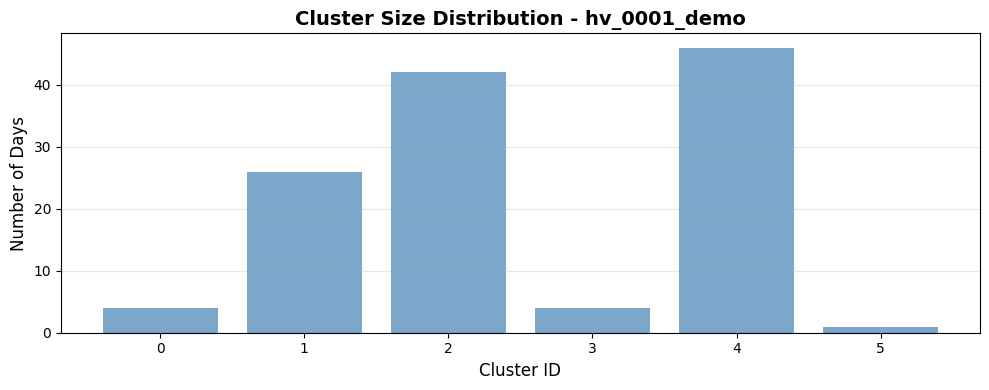


hv_0001_demo のクラスタサイズ:
  Cluster 0: 4日
  Cluster 1: 26日
  Cluster 2: 42日
  Cluster 3: 4日
  Cluster 4: 46日
  Cluster 5: 1日


In [8]:
# hashvinごとのクラスタサイズを可視化
for hashvin in hashvins:
    if hashvin not in clusterer.clustering_results_:
        continue
    
    cluster_sizes = clusterer.clustering_results_[hashvin]['cluster_sizes']
    
    plt.figure(figsize=(10, 4))
    plt.bar(cluster_sizes.keys(), cluster_sizes.values(), color='steelblue', alpha=0.7)
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Number of Days', fontsize=12)
    plt.title(f'Cluster Size Distribution - {hashvin}', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{hashvin} のクラスタサイズ:")
    for cluster_id, size in sorted(cluster_sizes.items()):
        print(f"  Cluster {cluster_id}: {size}日")


### 6.2 クラスタ別ヒートマップ（時間×場所）


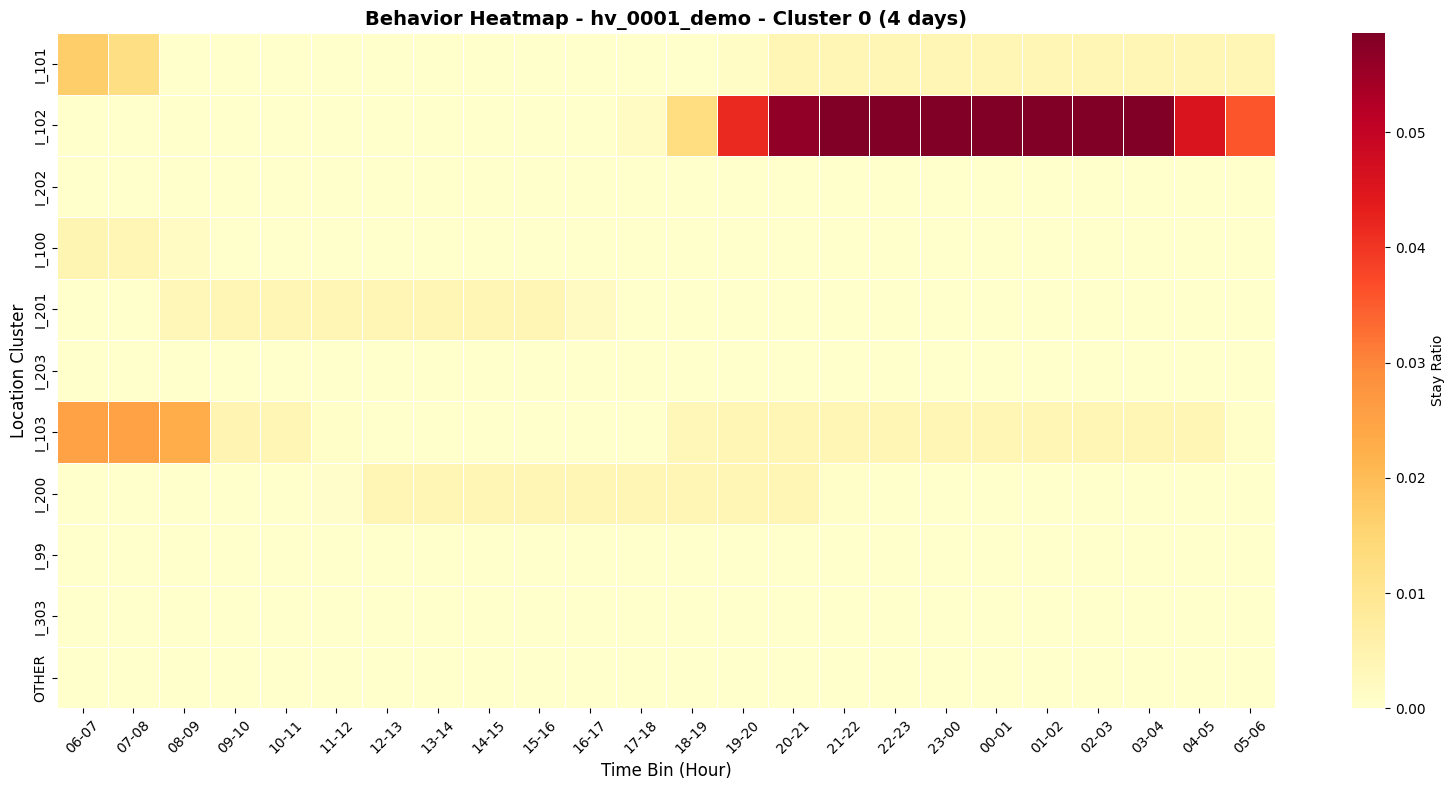

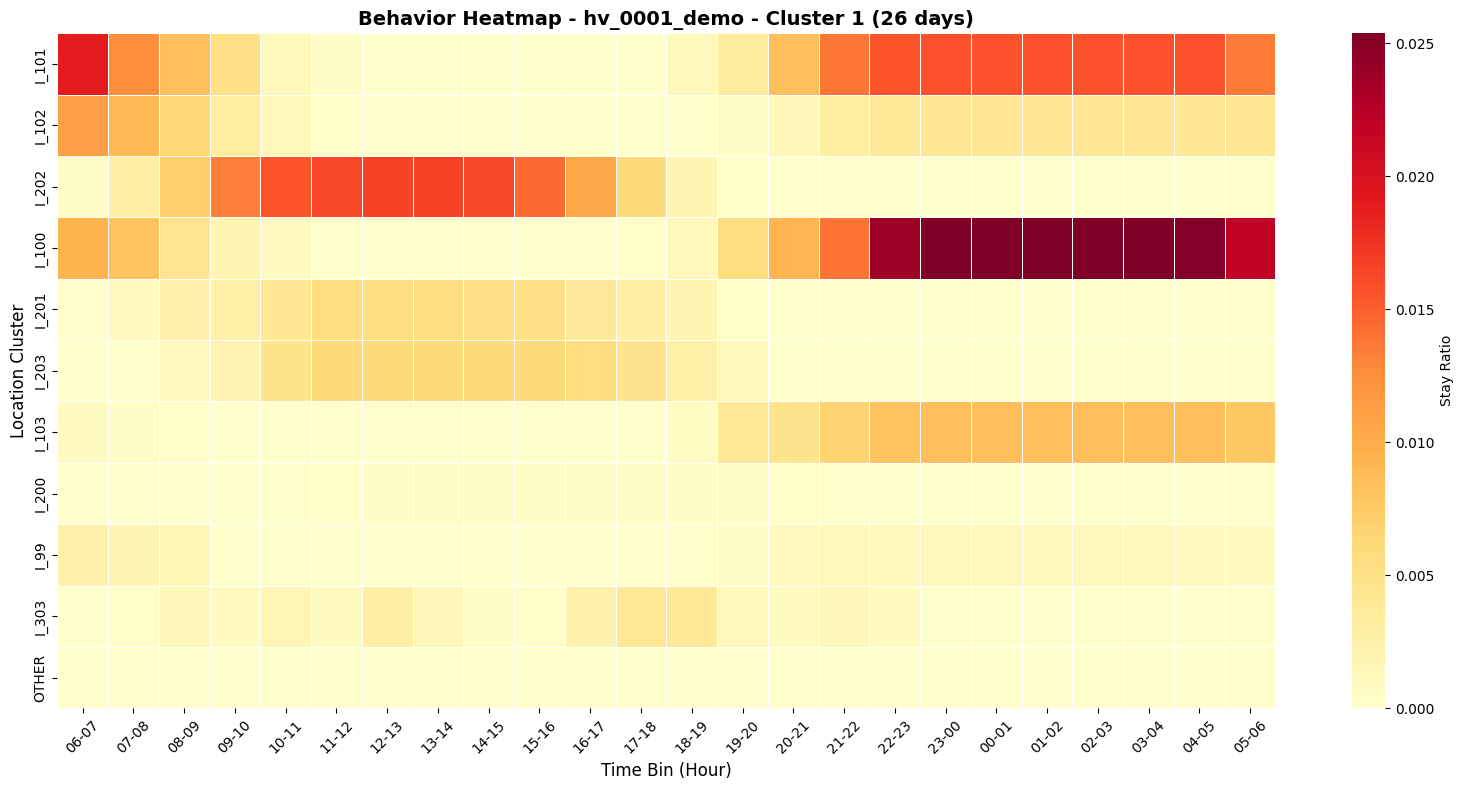

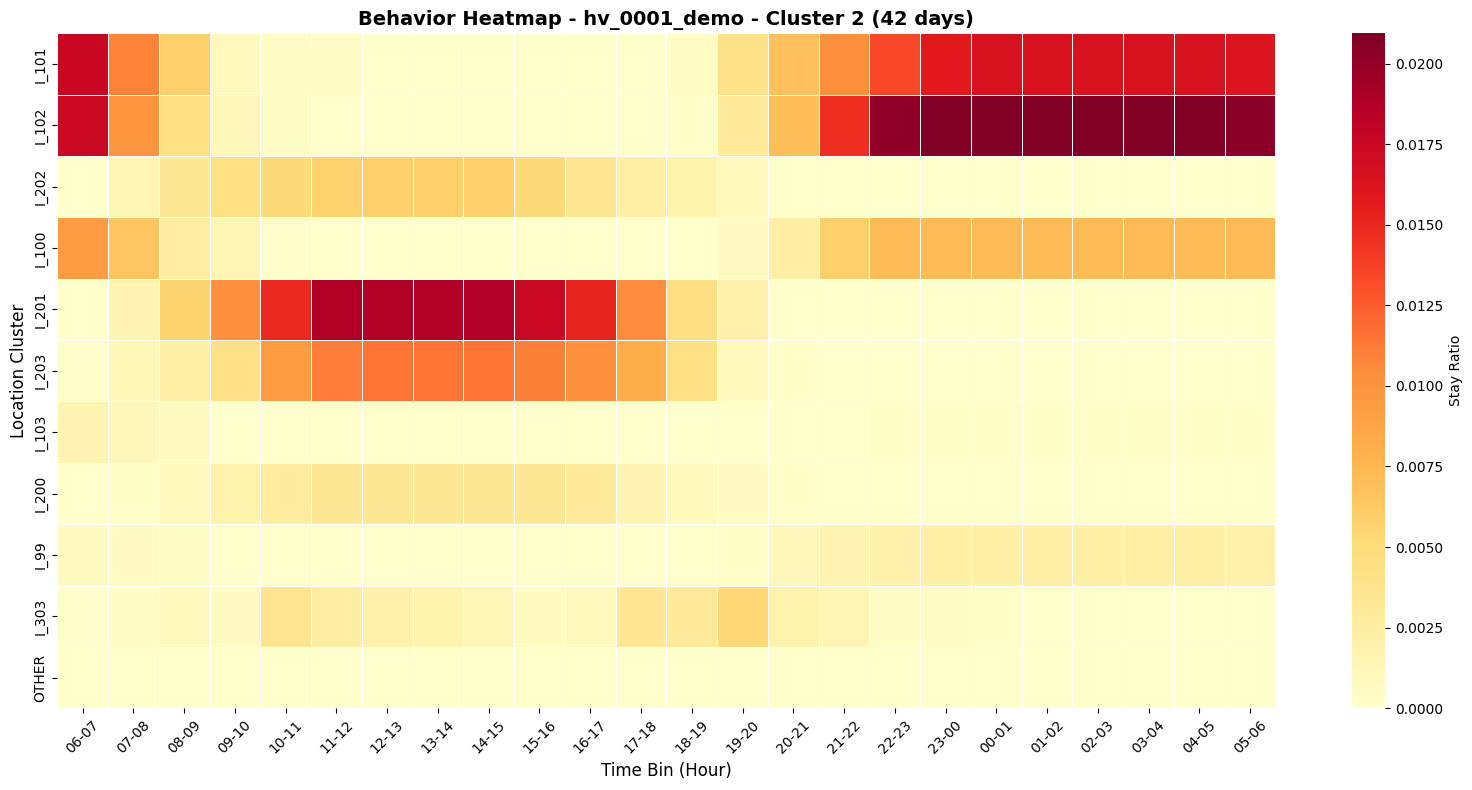

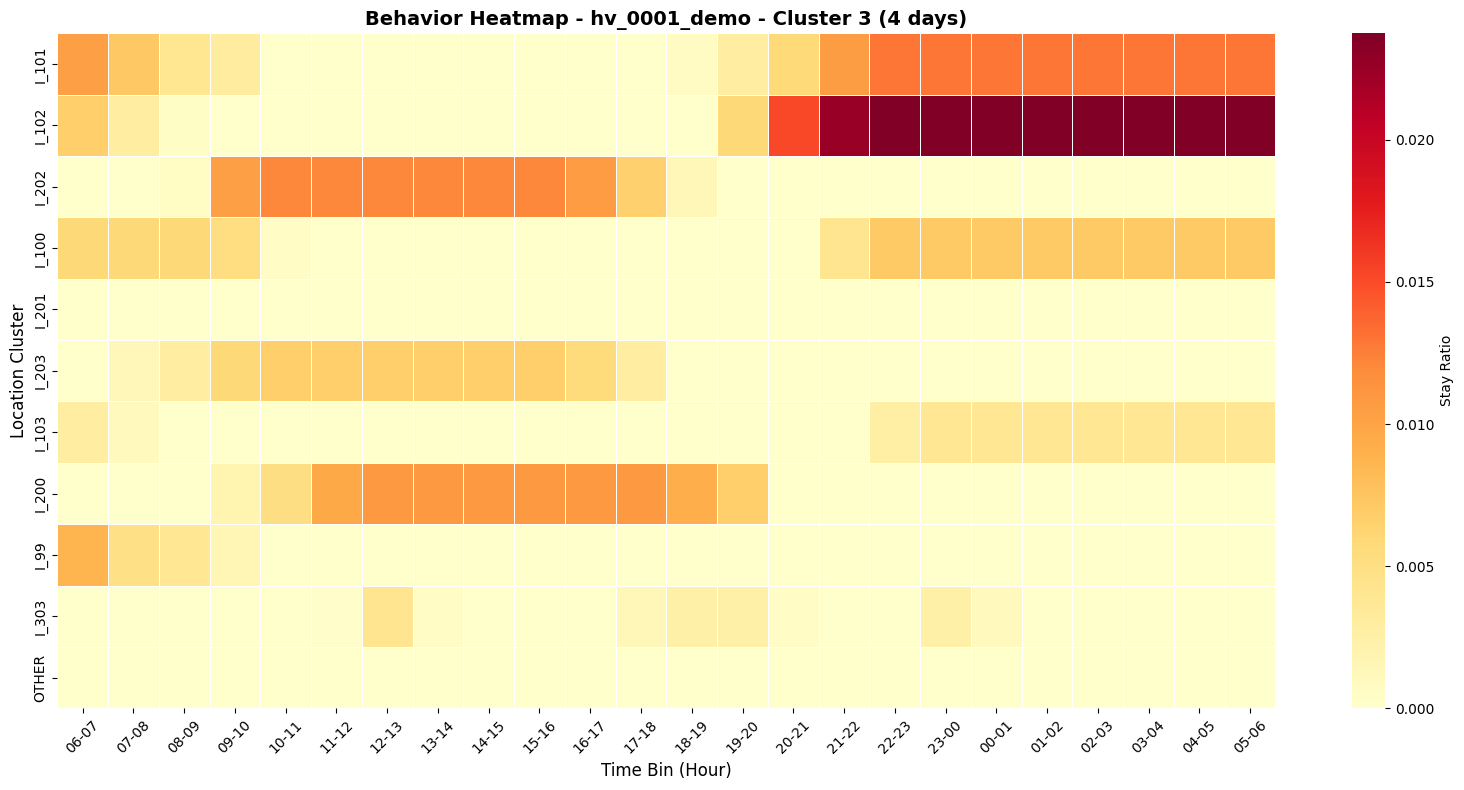

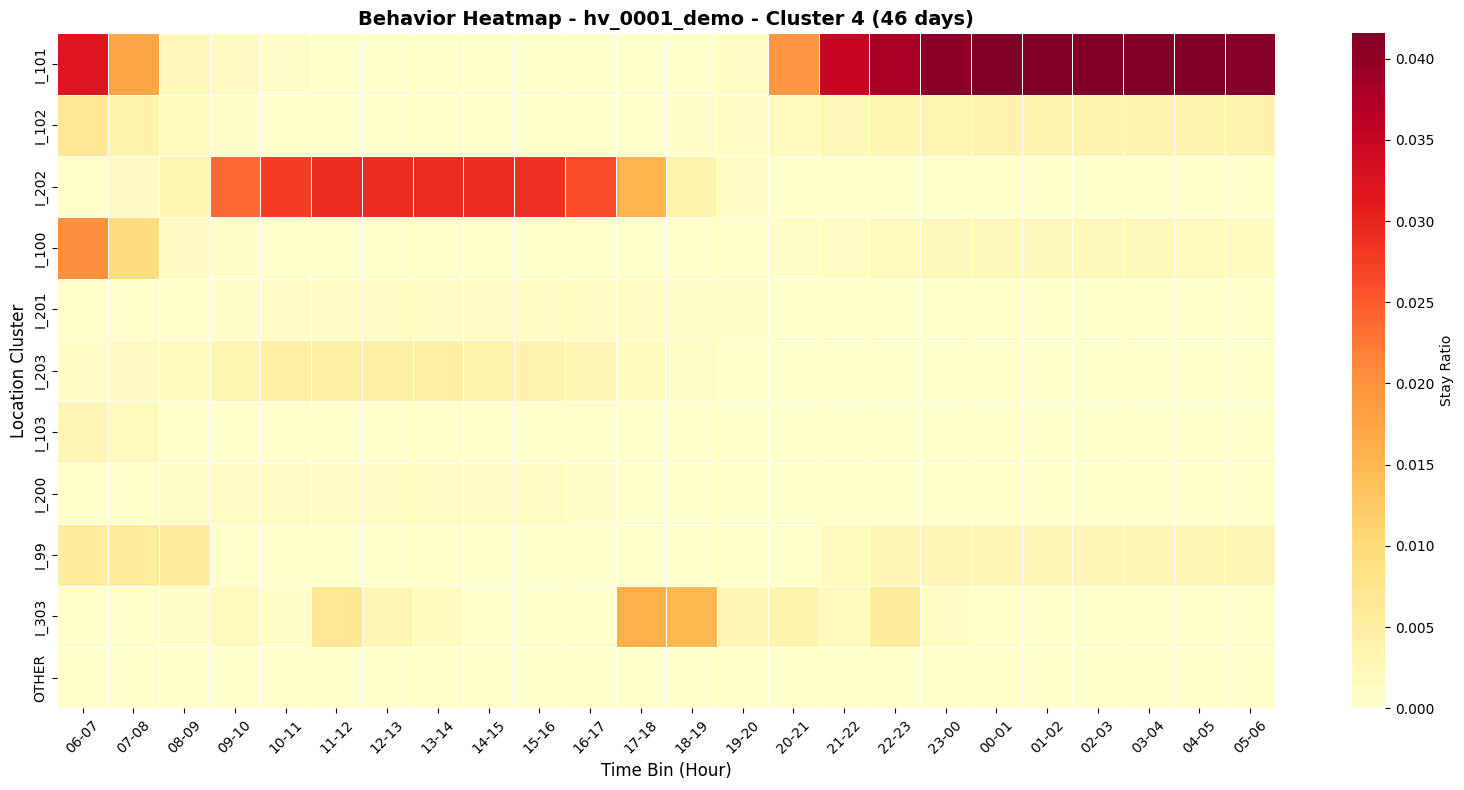

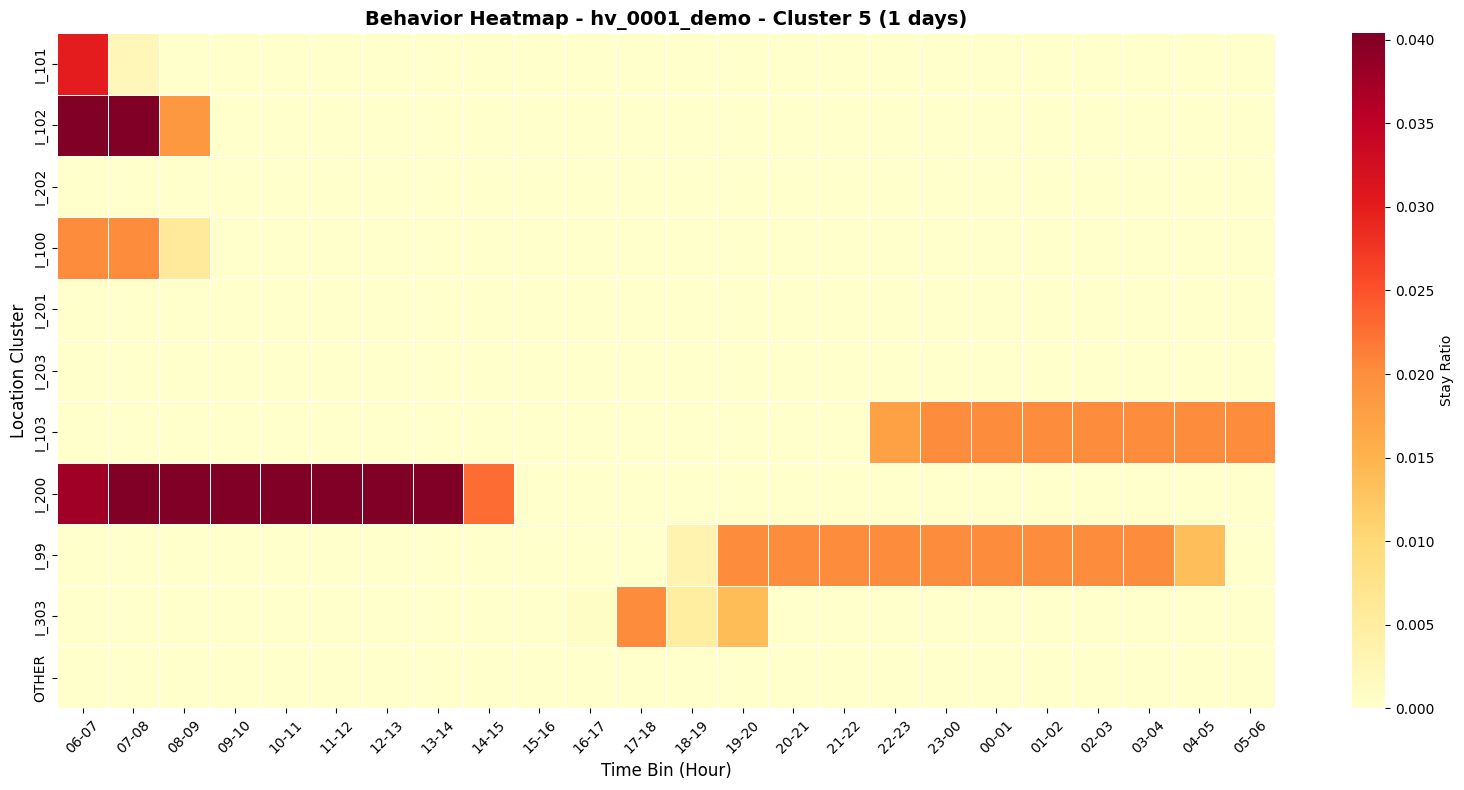

In [9]:
def plot_cluster_heatmap(daily_vectors, clusterer, hashvin, cluster_id, top_n_clusters=10):
    """
    クラスタ別の行動ヒートマップを描画
    
    Args:
        daily_vectors: 日次行動ベクトル
        clusterer: BehaviorPatternClusterer インスタンス
        hashvin: 対象hashvin
        cluster_id: クラスタID
        top_n_clusters: 表示する上位クラスタ数
    """
    # クラスタプロファイル取得
    profiles = clusterer.get_cluster_profiles(df_clustered, hashvin)
    
    if cluster_id not in profiles:
        print(f"Cluster {cluster_id} が見つかりません")
        return
    
    profile = profiles[cluster_id]
    avg_vector = profile['avg_vector']
    
    # 時間ビン×場所クラスタのマトリクスを作成
    time_processor = TimeRangeProcessor(config)
    hour_bins = time_processor.get_hour_bins()
    
    # 上位クラスタの滞在比率を集計
    top_clusters = vectorizer.top_clusters_[:top_n_clusters]
    
    matrix = []
    for cluster in top_clusters:
        row = []
        for hour_bin in hour_bins:
            col_name = f'ratio__{hour_bin}__{cluster}'
            if col_name in avg_vector.index:
                row.append(avg_vector[col_name])
            else:
                row.append(0)
        matrix.append(row)
    
    # OTHERも追加
    other_row = []
    for hour_bin in hour_bins:
        col_name = f'ratio_OTHER__{hour_bin}'
        if col_name in avg_vector.index:
            other_row.append(avg_vector[col_name])
        else:
            other_row.append(0)
    matrix.append(other_row)
    
    matrix = np.array(matrix)
    
    # ヒートマップ描画
    plt.figure(figsize=(16, 8))
    sns.heatmap(matrix, 
                xticklabels=hour_bins,
                yticklabels=top_clusters + ['OTHER'],
                cmap='YlOrRd',
                cbar_kws={'label': 'Stay Ratio'},
                linewidths=0.5,
                linecolor='white')
    
    plt.xlabel('Time Bin (Hour)', fontsize=12)
    plt.ylabel('Location Cluster', fontsize=12)
    plt.title(f'Behavior Heatmap - {hashvin} - Cluster {cluster_id} ({profile["size"]} days)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 各hashvinの各クラスタについてヒートマップを描画
for hashvin in hashvins:
    if hashvin not in clusterer.clustering_results_:
        continue
    
    profiles = clusterer.get_cluster_profiles(df_clustered, hashvin)
    
    for cluster_id in sorted(profiles.keys()):
        plot_cluster_heatmap(daily_vectors, clusterer, hashvin, cluster_id)


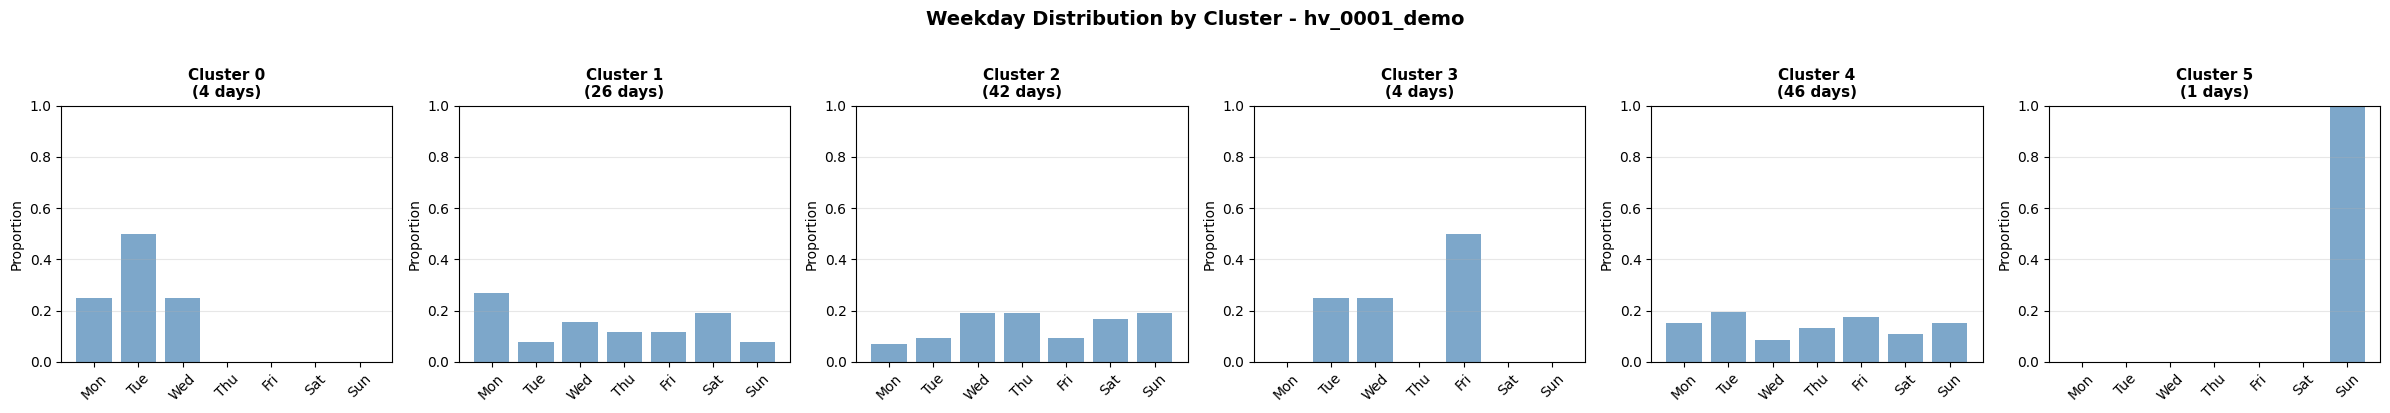

In [10]:
def plot_weekday_distribution(daily_vectors, clusterer, hashvin):
    """
    クラスタ別の曜日分布を描画
    
    Args:
        daily_vectors: 日次行動ベクトル
        clusterer: BehaviorPatternClusterer インスタンス
        hashvin: 対象hashvin
    """
    profiles = clusterer.get_cluster_profiles(df_clustered, hashvin)
    
    weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    n_clusters = len(profiles)
    
    fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4))
    if n_clusters == 1:
        axes = [axes]
    
    for idx, (cluster_id, profile) in enumerate(sorted(profiles.items())):
        weekday_dist = profile['weekday_dist']
        
        # 曜日0-6の全てを含むように補完
        full_dist = pd.Series(0.0, index=range(7))
        full_dist.update(weekday_dist)
        
        axes[idx].bar(range(7), full_dist.values, color='steelblue', alpha=0.7)
        axes[idx].set_xticks(range(7))
        axes[idx].set_xticklabels(weekday_names, rotation=45)
        axes[idx].set_ylabel('Proportion', fontsize=10)
        axes[idx].set_title(f'Cluster {cluster_id}\n({profile["size"]} days)', 
                           fontsize=11, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].set_ylim(0, 1)
    
    plt.suptitle(f'Weekday Distribution by Cluster - {hashvin}', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 各hashvinについて曜日分布を描画
for hashvin in hashvins:
    if hashvin not in clusterer.clustering_results_:
        continue
    
    plot_weekday_distribution(daily_vectors, clusterer, hashvin)


### 6.4 代表日の抽出


In [11]:
# 各クラスタの代表日を表示
for hashvin in hashvins:
    if hashvin not in clusterer.clustering_results_:
        continue
    
    print(f"\n{'='*60}")
    print(f"代表日リスト - {hashvin}")
    print(f"{'='*60}")
    
    profiles = clusterer.get_cluster_profiles(df_clustered, hashvin)
    
    for cluster_id, profile in sorted(profiles.items()):
        print(f"\nCluster {cluster_id} ({profile['size']}日):")
        for i, date in enumerate(profile['representative_dates'][:3], 1):
            print(f"  {i}. {date}")



代表日リスト - hv_0001_demo

Cluster 0 (4日):
  1. 2025-12-23 06:00:00+09:00
  2. 2025-10-20 06:00:00+09:00
  3. 2025-12-17 06:00:00+09:00

Cluster 1 (26日):
  1. 2025-11-13 06:00:00+09:00
  2. 2025-11-10 06:00:00+09:00
  3. 2025-10-29 06:00:00+09:00

Cluster 2 (42日):
  1. 2025-10-14 06:00:00+09:00
  2. 2025-10-01 06:00:00+09:00
  3. 2025-11-29 06:00:00+09:00

Cluster 3 (4日):
  1. 2025-11-18 06:00:00+09:00
  2. 2025-12-05 06:00:00+09:00
  3. 2025-11-05 06:00:00+09:00

Cluster 4 (46日):
  1. 2025-09-11 06:00:00+09:00
  2. 2025-09-05 06:00:00+09:00
  3. 2025-09-02 06:00:00+09:00

Cluster 5 (1日):
  1. 2025-12-14 06:00:00+09:00


### 6.5 クラスタリングメトリクスの可視化


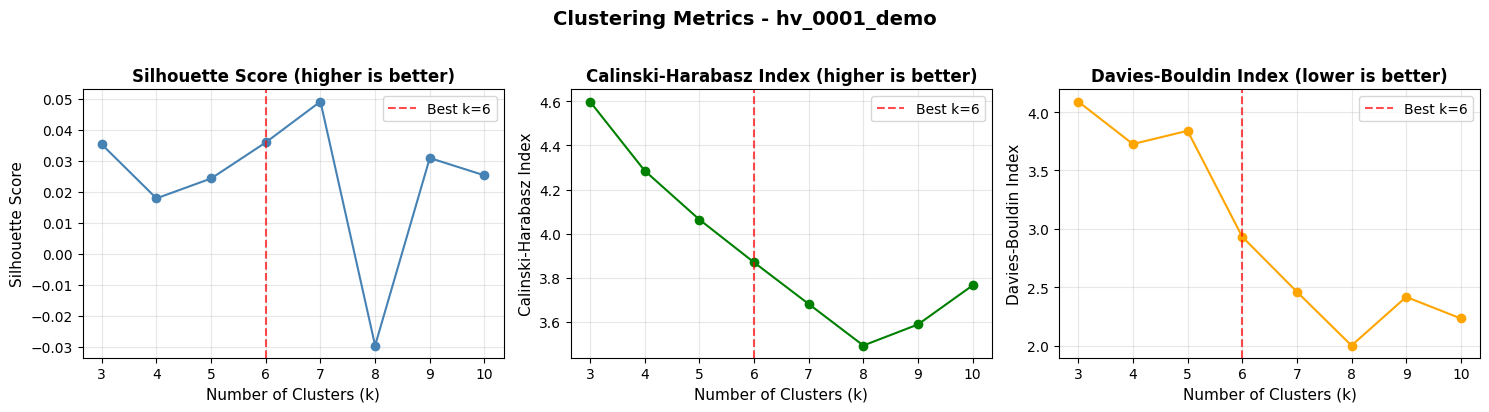

In [12]:
def plot_clustering_metrics(clusterer, hashvin):
    """
    クラスタリングメトリクスを可視化
    
    Args:
        clusterer: BehaviorPatternClusterer インスタンス
        hashvin: 対象hashvin
    """
    if hashvin not in clusterer.clustering_results_:
        return
    
    metrics = clusterer.clustering_results_[hashvin]['metrics_history']
    best_k = clusterer.clustering_results_[hashvin]['best_k']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Silhouette Score
    axes[0].plot(metrics['k'], metrics['silhouette'], marker='o', color='steelblue')
    axes[0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
    axes[0].set_ylabel('Silhouette Score', fontsize=11)
    axes[0].set_title('Silhouette Score (higher is better)', fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    axes[0].legend()
    
    # Calinski-Harabasz Index
    axes[1].plot(metrics['k'], metrics['calinski_harabasz'], marker='o', color='green')
    axes[1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
    axes[1].set_ylabel('Calinski-Harabasz Index', fontsize=11)
    axes[1].set_title('Calinski-Harabasz Index (higher is better)', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    
    # Davies-Bouldin Index
    axes[2].plot(metrics['k'], metrics['davies_bouldin'], marker='o', color='orange')
    axes[2].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k={best_k}')
    axes[2].set_xlabel('Number of Clusters (k)', fontsize=11)
    axes[2].set_ylabel('Davies-Bouldin Index', fontsize=11)
    axes[2].set_title('Davies-Bouldin Index (lower is better)', fontsize=12, fontweight='bold')
    axes[2].grid(alpha=0.3)
    axes[2].legend()
    
    plt.suptitle(f'Clustering Metrics - {hashvin}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# 各hashvinについてメトリクスを可視化
for hashvin in hashvins:
    plot_clustering_metrics(clusterer, hashvin)


## 7. サマリーレポート


In [13]:
# サマリーレポート作成
print("="*60)
print("分析サマリーレポート")
print("="*60)

for hashvin in hashvins:
    if hashvin not in clusterer.clustering_results_:
        continue
    
    print(f"\n【{hashvin}】")
    
    # 基本情報
    result = clusterer.clustering_results_[hashvin]
    best_k = result['best_k']
    cluster_sizes = result['cluster_sizes']
    
    print(f"  最適クラスタ数: {best_k}")
    print(f"  総分析日数: {sum(cluster_sizes.values())}日")
    
    # クラスタサイズ
    print("\n  クラスタ構成:")
    for cluster_id, size in sorted(cluster_sizes.items()):
        percentage = size / sum(cluster_sizes.values()) * 100
        print(f"    Cluster {cluster_id}: {size}日 ({percentage:.1f}%)")
    
    # 曜日傾向（簡易版）
    profiles = clusterer.get_cluster_profiles(df_clustered, hashvin)
    print("\n  主な曜日傾向:")
    weekday_names = ['月', '火', '水', '木', '金', '土', '日']
    
    for cluster_id, profile in sorted(profiles.items()):
        weekday_dist = profile['weekday_dist']
        if len(weekday_dist) > 0:
            top_weekday = weekday_dist.idxmax()
            top_ratio = weekday_dist.max()
            print(f"    Cluster {cluster_id}: {weekday_names[top_weekday]}が多い ({top_ratio:.1%})")

print("\n" + "="*60)
print("✓ 分析完了")
print("="*60)


分析サマリーレポート

【hv_0001_demo】
  最適クラスタ数: 6
  総分析日数: 123日

  クラスタ構成:
    Cluster 0: 4日 (3.3%)
    Cluster 1: 26日 (21.1%)
    Cluster 2: 42日 (34.1%)
    Cluster 3: 4日 (3.3%)
    Cluster 4: 46日 (37.4%)
    Cluster 5: 1日 (0.8%)

  主な曜日傾向:
    Cluster 0: 火が多い (50.0%)
    Cluster 1: 月が多い (26.9%)
    Cluster 2: 水が多い (19.0%)
    Cluster 3: 金が多い (50.0%)
    Cluster 4: 火が多い (19.6%)
    Cluster 5: 日が多い (100.0%)

✓ 分析完了


## 8. 次のステップへの示唆

### 特徴量設計への還元

上記のクラスタリング結果から、以下のような「直前N時間」の特徴量が有効と考えられます：

1. **場所ベース特徴**
   - `home様クラスタ_ratio_last6h`: 直前6時間でhome様クラスタに滞在していた比率
   - `work様クラスタ_ratio_last6h`: 直前6時間でwork様クラスタに滞在していた比率
   - `unique_clusters_last3h`: 直前3時間で訪問したクラスタの種類数

2. **時間帯ベース特徴**
   - `morning_activity_ratio`: 午前中（06-12時）の活動比率
   - `evening_activity_ratio`: 夕方（16-20時）の活動比率

3. **行動パターンベース特徴**
   - `current_day_pattern`: その日の行動パターンクラスタID
   - `prev_day_pattern`: 前日の行動パターンクラスタID
   - `pattern_transition`: パターン遷移フラグ

これらの特徴量を放置場所予測モデルに投入することで、予測精度の向上が期待されます。
